In [257]:
def pp(s):
    print(s)
    return s + "\n"

# Datamodel for the flow network

In [311]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")

# Next two lines forc outomatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

import pfs_netflow.datamodel as dm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the catalogs, compute visibility ... 

In [312]:
BLOCKLENGTH = 300. # block exposure time in s, to simulate three consequtive exposures
BLOCKLENGTH = 900. # block exposure time in s

In [313]:
# Define target lists.
fscience_targets = "../pfs_target_list/pfs_preliminary_target_cosmology.dat"
fcal_stars       = "../pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
fsky_pos         = "../pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"

# Load target lists.
from astropy.io import ascii

science_targets = ascii.read(fscience_targets)

cal_stars = ascii.read(fcal_stars)

sky_pos = ascii.read(fsky_pos)

# Conversion of column names, this should not be necessary anymore in future versions.
for t in [science_targets, cal_stars, sky_pos]:
    t['R'].name = 'RA'
    t['Dec'].name = 'DEC'
    t['Exposure'].name = 'EXP_TIME'

In [324]:
# Convert data to lists for ETS.
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{}'.format(t, p)
    

pointing_RA, pointing_DEC = 33.97, -4.24
DRMAX_SQ = (1800./3600.)**2.

dra = (ra - pointing_RA)*cos(deg2rad(dec))
ddec = dec - pointing_DEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

In [325]:
# assign random priorities between 1 and 3 for the  science targets
from numpy import random
from numpy import array

random.seed(42)

N = len( science_targets['Priority'] )
newpri = array( random.uniform(1.,4., size=N) , dtype=int)
science_targets['Priority'] = newpri

priorities = hstack([newpri,cal_stars['Priority'],sky_pos['Priority']]).tolist()

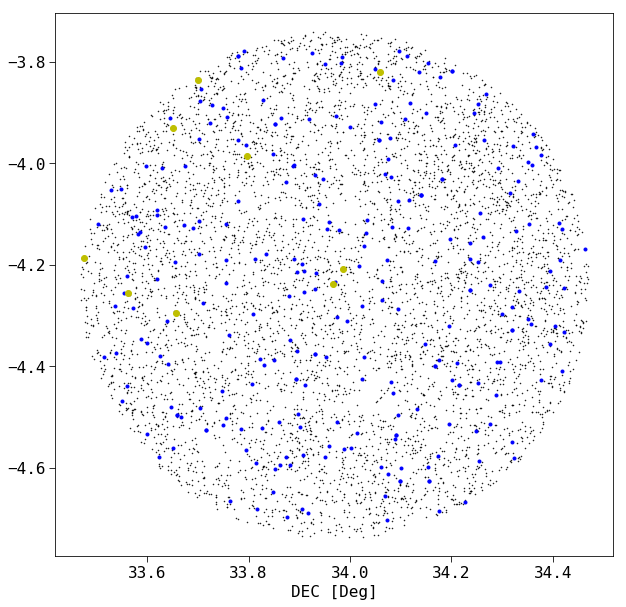

In [326]:
c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

f = plt.figure(figsize=[10,10])
plt.plot(np.array(ra)[ii_sci],np.array(dec)[ii_sci],'.', ms=1)
plt.plot(np.array(ra)[ii_sky],np.array(dec)[ii_sky],'b.' )
plt.plot(np.array(ra)[ii_cal],np.array(dec)[ii_cal],'yo' )
plt.axis('equal')
plt.xlabel("RA [Deg]")
plt.xlabel("DEC [Deg]")

In [327]:
 
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = int(nrv)
    
print "Required revisits", unique( [v for v in nreqv_dict.itervalues()] )

Required revisits [1]


In [328]:
# Call ETS via  the pyETS interface. Compute x,y positions of targets, for a given 
# pointing RA, DEC, and position angle and also compute which target is observable by
# which cobra.
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/src/ets_fiber_assigner")
from pyETS import *

# Initialize the ETS class with target data, telescope pointing and observation time
ets = ETShelper(ID, ra, dec, exp_times, priorities, pointing_RA, pointing_DEC, 0, "2016-04-03T08:00:00Z")

# obtain dot positions
dots = ets.getDotpos()

# obtain cobra centers
cobras = ets.getFiberpos()

# obtain targt positions within the focal plane
targets = ets.getTgtpos()

# get a list of targets, and a list of Cobras that can observe them
visibilities = ets.getVis()

# Assign targetclass labels according to traget type and priority
from numpy import unique

# Build dict that holds class descriptor string for each target.
# This is needed later because ETS does not preserve the order.
tclasses =   [class_dict[t] for t in targets]
print(unique(tclasses))

# Build dict that holds required number of visits each target.
nreqvisits = [nreqv_dict[t] for t in targets]


['cal_P1' 'sci_P1' 'sci_P2' 'sci_P3' 'sky_P1']


In [329]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.

def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = {}

    cnt = 0
    for v in visibilities:
        t = v
        cc = visibilities[v]

        for c in cc:
            if ivisibilities.has_key(c):
                ivisibilities[c].append(v)
            else:
                ivisibilities[c] = [v]

    return ivisibilities

ivisibilities = invert_vis(visibilities)   

nsci = 0
ncal = 0
nsky = 0
for c in ivisibilities:
    for t in ivisibilities[c]:
        nsci += class_dict[t][:3] == 'sci' 
        ncal += class_dict[t][:3] == 'cal'
        nsky += class_dict[t][:3] == 'sky'
        

In [331]:
nsci = 0
ncal = 0
nsky = 0

for tid,v in visibilities.iteritems():
    if len(v) > 0:
        if class_dict[tid][:3] == 'cal':
            ncal += 1
        elif class_dict[tid][:3] == 'sky':
            nsky += 1
        elif class_dict[tid][:3] == 'sci':
            nsci += 1
print("{} cobras have at least one target in reach.".format(len(ivisibilities)))
print("{} science targets\n{} calibration targets, \
and \n{} sky positions are in reach of at least one cobra.".format(nsci, ncal, nsky))  

1479 cobras have at least one target in reach.
5116 science targets
7 calibration targets, and 
239 sky positions are in reach of at least one cobra.


# run the ETS solver

In [332]:
def fil(xx,bb):
    """
    Takes a list of objects and a boolean list of same length.
    Retruns a list with all thos object for which the boolean
    input list had a True.
    """
    new = []
    for x,b in zip(xx,bb):
        if b: 
            new.append(x)
    return new

In [344]:
import numpy as np
import time
    
NVISISTS = 5
ii = np.full_like(ID, True, dtype=bool)

# set priorities 
priorities2 = [15]*len(science_targets) + [1]*len(cal_stars) + [1]*len(sky_pos)

for v in range(NVISISTS):
    nsci_observed = 0
    ncal_observed = 0
    nsky_observed = 0
    print("Visit {}".format(v))
    print(" Number of remaining targets to observe: {}".format(sum(ii)))
    
    start_time = time.time()
    ets2 = ETShelper(fil(ID,ii), fil(ra,ii), fil(dec,ii), fil(exp_times,ii), fil(priorities2,ii), pointing_RA, pointing_DEC, 0, "2016-04-03T08:00:00Z")
    res = ets2.getObservation("new")
    time_to_build = time.time() - start_time
    pp(" Time to solve: {:.4e} s".format(time_to_build))

    N = len( res.items() )
    print(" Observed {} targets.".format(N))
    # figure which out of all potential science targets have been observed
    # and mark them as observed
    observed_ids = [r for r in res]
    
    for t in observed_ids:
        if class_dict[t][:3] == 'sci': 
            ii[ ID.index(t) ] = False
            nsci_observed += 1
        if class_dict[t][:3] == 'cal': 
            ncal_observed += 1
        if class_dict[t][:3] == 'sky': 
            nsky_observed += 1
 
    nsci_observed_total = sum( [class_dict[t][:3] == 'sci' for t in fil(ID,~ii)] )
    
    print(" Observed {} science targets, {} calibration targets and {} sky positions"\
          .format(nsci_observed, ncal_observed, nsky_observed))

    print(" Observed {} science targets in total.".format(nsci_observed_total))
    print("")


Visit 0
 Number of remaining targets to observe: 6006
 Time to solve: 8.9352e-02 s
 Observed 1468 targets.
 Observed 1411 science targets, 1 calibration targets and 56 sky positions
 Observed 1411 science targets in total.

Visit 1
 Number of remaining targets to observe: 4595
 Time to solve: 5.3036e-02 s
 Observed 1378 targets.
 Observed 1282 science targets, 3 calibration targets and 93 sky positions
 Observed 2693 science targets in total.

Visit 2
 Number of remaining targets to observe: 3313
 Time to solve: 4.2160e-02 s
 Observed 1177 targets.
 Observed 1037 science targets, 3 calibration targets and 137 sky positions
 Observed 3730 science targets in total.

Visit 3
 Number of remaining targets to observe: 2276
 Time to solve: 3.2750e-02 s
 Observed 864 targets.
 Observed 676 science targets, 4 calibration targets and 184 sky positions
 Observed 4406 science targets in total.

Visit 4
 Number of remaining targets to observe: 1600
 Time to solve: 2.4580e-02 s
 Observed 545 targets

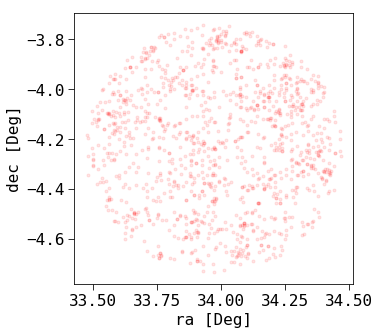

In [334]:
# Plot unobserved targets
from numpy import array
from matplotlib import pyplot as plt
% matplotlib inline
f = plt.figure(figsize=[5,5])

#plt.plot(fil(ra,~ii), fil(dec,~ii), '.', color='k')
plt.plot(fil(ra,ii), fil(dec,ii), '.', color='r', alpha=0.1)

plt.ylabel('dec [Deg]')
plt.xlabel('ra [Deg]')
#plt.axis("equal")

#plt.xlim([33.25,34.74])
#plt.ylim([-5.25,-3.75])

# Execute netflow

In [354]:
from numpy import inf

# Here we define the costs

cost_dict = {}
# For each target class we define the cost of non-observation
# and non-completion as a two-tuple. The cost of non-completion 
# is typically larger as partial completion of objects shoudl be avoided.
cost_dict['sci_P1'] = (1000.,1e9)
cost_dict['sci_P2'] = (100.,1e9)
cost_dict['sci_P3'] = (10.,1e9)

# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P1'] = 10000.
cost_dict['sky_P1'] = 10000.

# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P1'] = inf
supply_dict['sci_P2'] = inf
supply_dict['sci_P3'] = inf

# need one calibration star per exposure
supply_dict['cal_P1'] = 6 # inf = try to get as amny as  possible
# need one sky positions per exposure
supply_dict['sky_P1'] = 184 # inf = try to get as amny as  possible



In [355]:
from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan

NVISITS = 5
COBRAS = []

# intermediate example
RMAX = 50.
CENTER = [-5.,90.]
name="intermediate"

# good minimal example
RMAX = 10.
CENTER = [-5.,90.]
name="minimal"

# do them all!
RMAX = 300.
CENTER = [-0.,0.]
name="all"

print("Creating graph ...")
g = buildSurveyPlan(cobras, targets, nreqvisits, visibilities, tclasses, cost_dict, supply_dict, NVISITS, \
                    RMAX, CENTER, COBRAS = COBRAS)
print("Done.")

for c in g.sciTargetClasses:
    
    nsci = 0
    nsci_reachable = 0
    for t in g.sciTargetClasses[c].targets.itervalues():
        if t.outarcs != []:
            nsci += 1
            nsci_reachable += 1
        
    print("Number of targets in {} is {}.".format(c, nsci ) )
    print("Number of observable targets in {} is {}.".format(c, nsci_reachable ) )
    
ncal = 0
ncal_reachable = 0
for t in g.calTargetClasses['TClass_cal_P1_v0'].targets.itervalues():
    if t.outarcs != []:
        ncal += 1
        ncal_reachable += 1
print("Number of calibration stars: {}".format(ncal) )
print("Number of observable calibration stars: {}".format( ncal_reachable )) 
            

nsky = 0
nsky_reachable = 0
for t in g.calTargetClasses['TClass_sky_P1_v0'].targets.itervalues():
    if t. outarcs != []:
        nsky += 1
        nsky_reachable += 1
print("Number of sky positions: {}".format(nsky) )
print("Number of observable sky positions: {}".format(nsky_reachable) )

if RMAX == 10. or False:
    plotSurveyPlan(g)

Creating graph ...
buildSurveyPlan 
Done.
Number of targets in TClass_sci_P1 is 1915.
Number of observable targets in TClass_sci_P1 is 1915.
Number of targets in TClass_sci_P2 is 1915.
Number of observable targets in TClass_sci_P2 is 1915.
Number of targets in TClass_sci_P3 is 1904.
Number of observable targets in TClass_sci_P3 is 1904.
Number of calibration stars: 7
Number of observable calibration stars: 7
Number of sky positions: 239
Number of observable sky positions: 239


In [356]:
from pfs_netflow.lp import buildLPProblem, computeStats, solve
from pulp import LpStatus, value


def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])


maxSeconds=600.

    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(NCalTargets/NVISITS))
summary += pp(" {} cobras".format(NCobras))
summary += pp("Will stop in any case after {} s.".format(maxSeconds))


summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

#visualizeSurveyPlan(g)

summary += pp("Building LP problem ...")
start_time = time.time()
prob, flows, cost = buildLPProblem(g)
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()
status = solve(prob, maxSeconds=maxSeconds)
time_to_solve = time.time() - start_time
summary += pp("Solve status is {}.".format( LpStatus[status] ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))

stats = computeStats(g, flows, cost)

summary += pp("{} = {}".format('Value of cost function',value(stats.cost) ) )
summary += pp("{} out of {} science targets get observed.".format(int(stats.NSciObs),NSciTargets))
summary += pp("For {} out of these all required exposures got allocated.".format(stats.NSciComplete))
summary += pp("{} targets get sent down the overflow arc.".format(stats.Noverflow))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats.Ncobras_used, NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats.Ncobras_fully_used))

setflows(g,flows)

NVISITS = 5
Searching optimal strategy to observe in 
 5 visits
 5734 science targets
 272 calib. targets
 2394 cobras
Will stop in any case after 600.0 s.
num nodes: 50142
num edges: 88143
Building LP problem ...
Building cost equation ...
 Time to completion: 13.19 s
Time to build model: 1.3271e+01 s
Solving LP problem ...
Solve status is Optimal.
Time to solve: 1.1619e+01 s
Value of cost function = 237340.0
4590 out of 5734 science targets get observed.
For 4590 out of these all required exposures got allocated.
1144.0 targets get sent down the overflow arc.
1478 out of 2394 cobras observed a target in one or more exposures.
647 cobras observed a target in all exposures.


In [366]:
for visit in g.visits:
    print("Visit {}".format(visit))
    nsci = 0
    ncal = 0
    nsky = 0
    for a in g.arcs.itervalues():
        n1,n2 = a.startnode,a.endnode

        if a.flow > 0.:
            #print n1,n2, a.flow, n2.visit
            #print type(n2) == dm.CobraVisit , n2.visit == visit , type(n1) == dm.TargetVisit
            #break
            if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.TargetVisit:
                    nsci += 1
            if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.CalTarget:
                    
                    if class_dict[ n1.id[2:-3] ][:3] == "sky":
                        nsky += 1
                    else:
                        ncal += 1 
    
    print("Observed {} science targets and {} cal. stars and {} sky positions.".format(nsci, ncal, nsky))
    


Visit 0
Observed 1071 science targets and 6 cal. stars and 184 sky positions.
Visit 1
Observed 906 science targets and 6 cal. stars and 184 sky positions.
Visit 2
Observed 802 science targets and 6 cal. stars and 184 sky positions.
Visit 3
Observed 762 science targets and 6 cal. stars and 184 sky positions.
Visit 4
Observed 1049 science targets and 6 cal. stars and 184 sky positions.


In [ ]:
RSEP = 5.

if RSEP > 0.:
    print("Finding collision pairs ...")
    tt = np.array( [t for t in g.targets.itervalues()] )
    tt_xy = [ (g.targets[t].x,g.targets[t].y) for t in g.targets]

    N = len(tt)

    from scipy.spatial import distance
    # calculat collisions from all pairwise separations
    colls = distance.cdist(tt_xy, tt_xy, 'euclidean') < RSEP
    # set lower diagonal to False, if we know that A collides with B already
    # then we don't need to take into account that B collides with A
    colls[ np.tril_indices(N) ] = False 

    coll_pairs = []
    for i,t1 in enumerate(tt):
        for t2 in tt[ colls[i] ].tolist():
            coll_pairs.append([t1,t2])
            #print t1.id,t2.id

    print( "Found {} collision pairs.".format(len( coll_pairs )) )

    #for tid,t in tt:
    #    prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.outarcs]) <= 1
    
    

In [ ]:
i = 0

t1,t2 = coll_pairs[i]

print type(t1) == SciTarget
print type(t1) == CalTarget

t2.outarcs

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.itervalues():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if flows.has_key(k):
        allflows.append(value(flows[k]))

print("All flows are: integer {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
if True:
    # plot solution
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
    plotSurveyPlan(g)
    #return g, stats, time_to_build, time_to_solve, status, prob, flows, cost, summary

In [ ]:
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

In [ ]:
!open .